<a href="https://colab.research.google.com/github/puneat/Audio_Sentiment/blob/puneet/Male_Augmented_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df=pd.read_csv('/gdrive/My Drive/Audio_files/augmented_male.csv')

In [5]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

#data before normalisation 
X_train[150:160]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
25546,5026,-14.112002,-14.107496,-15.657149,-13.969799,-13.662415,-13.825943,-12.160050,-13.053829,-14.587437,-14.566971,-16.813292,-16.857661,-15.410041,-14.769906,-15.731511,-16.140087,-16.171508,-16.442697,-19.555999,-15.937601,-17.000396,-16.878430,-14.445776,-13.387809,-14.524242,-17.133413,-18.045136,-15.868452,-15.255581,-14.645007,-14.787662,-15.294490,-15.522479,-14.042150,-13.822708,-14.109512,-15.330890,-16.120015,-14.742948,...,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,-58.950093,0.000000,0.000000,0.000000
10030,4900,-13.962348,-13.755355,-12.839753,-12.126180,-12.334445,-14.209770,-15.682468,-16.645826,-15.196609,-15.234427,-16.239806,-16.409561,-15.685499,-16.215800,-15.979171,-16.586600,-15.079022,-15.838565,-17.116956,-16.939314,-17.740629,-14.053291,-12.176705,-9.615477,-10.727766,-12.606435,-13.393894,-14.625558,-18.658115,-18.769865,-16.755341,-15.134608,-14.497727,-14.908190,-14.252991,-16.055676,-19.016328,-17.994617,-16.308685,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17775,2385,-15.756500,-16.546766,-18.668785,-20.295775,-20.252229,-19.973505,-14.957309,-13.032393,-13.226729,-12.019633,-11.701265,-13.639612,-15.007760,-13.130328,-14.356660,-15.158608,-15.650797,-14.120793,-15.298289,-15.385646,-12.332873,-11.409579,-11.669877,-11.534399,-13.621097,-14.388859,-14.699862,-14.673920,-14.540961,-15.574082,-15.542159,-17.762058,-16.551565,-16.901788,-15.465172,-16.697107,-16.093616,-16.645807,-17.007253,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11742,1482,-22.637107,-22.278907,-21.260805,-21.072165,-18.232183,-18.054798,-18.957017,-18.210223,-18.305632,-19.180165,-20.572896,-20.274026,-17.133486,-18.366031,-20.565360,-21.375259,-21.316668,-18.987485,-19.444356,-19.078681,-19.597857,-19.982705,-19.172802,-19.313028,-20.097410,-19.385713,-18.937610,-19.531885,-21.191990,-22.736574,-21.328672,-19.145389,-17.787788,-18.555769,-18.104923,-18.865246,-19.254677,-18.015346,-20.909470,...,-53.721505,-53.721505,-53.721505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20364,4974,-10.619891,-12.823736,-15.739756,-12.996537,-13.391316,-16.873390,-16.213228,-16.169481,-16.942668,-15.832085,-17.278013,-17.040274,-16.224685,-14.897918,-15.367981,-16.731540,-17.923335,-15.204795,-15.293387,-17.319536,-19.189689,-17.408486,-15.222235,-12.609681,-12.799380,-14.650097,-13.857467,-15.506392,-17.394646,-20.167824,-19.646835,-15.121308,-14.162546,-16.311665,-15.620933,-15.974706,-16.648024,-18.

In [6]:
# data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
25546,1.661131,0.499256,0.494079,0.453235,0.547577,0.550281,0.524716,0.622285,0.551358,0.431702,0.422244,0.261176,0.254402,0.349038,0.387413,0.317046,0.288278,0.284804,0.264887,0.043560,0.294843,0.217021,0.222525,0.390986,0.465605,0.383494,0.192829,0.120891,0.276260,0.317238,0.358002,0.339789,0.289872,0.260805,0.387389,0.404202,0.373702,0.251711,0.174564,0.310689,...,-1.510082,-1.496787,-1.483196,-1.508697,-1.497801,-1.487971,-1.518895,-1.516318,-1.546701,-1.545738,-1.545519,-1.579793,-1.580085,-1.580044,-1.618963,-1.619848,-1.621569,-1.657788,-1.659945,-1.659348,-1.688230,-1.689313,-1.691265,-1.721323,-1.721027,-1.721263,-1.763596,-1.763803,-1.763032,-1.805243,-1.809658,-1.855951,-1.863336,-1.869355,-1.920902,-1.927358,-1.930787,0.614755,0.609654,0.606057
10030,1.576191,0.508008,0.515378,0.631536,0.665481,0.636449,0.499474,0.386787,0.307080,0.389502,0.375825,0.301093,0.285604,0.329901,0.286934,0.299816,0.257157,0.361073,0.307095,0.214068,0.224663,0.165084,0.421199,0.550921,0.732936,0.654729,0.519843,0.461009,0.368358,0.059735,0.036385,0.181305,0.303199,0.349246,0.310066,0.364547,0.189407,-0.105665,-0.010001,0.154453,...,0.895242,0.899141,0.903769,0.874428,0.877154,0.880091,0.852032,0.852674,0.827146,0.827819,0.827892,0.803812,0.802528,0.801911,0.774669,0.774713,0.773869,0.752228,0.751539,0.752097,0.732832,0.732684,0.732169,0.715267,0.715685,0.714723,0.692125,0.692477,0.693464,0.672942,0.672272,0.652158,0.650567,0.650132,0.630562,0.629371,0.629303,0.614755,0.609654,0.606057
17775,-0.119230,0.403078,0.346542,0.262641,0.143014,0.122689,0.120436,0.435269,0.552815,0.525963,0.599401,0.616998,0.478482,0.376986,0.501352,0.412695,0.356683,0.321156,0.427109,0.341207,0.333513,0.544507,0.607114,0.586645,0.596949,0.448018,0.391087,0.365511,0.364775,0.371320,0.285561,0.279019,0.084190,0.171989,0.132072,0.252833,0.128665,0.177749,0.122797,0.084747,...,0.895242,0.899141,0.903769,0.874428,0.877154,0.880091,0.852032,0.852674,0.827146,0.827819,0.827892,0.803812,0.802528,0.801911,0.774669,0.774713,0.773869,0.752228,0.751539,0.752097,0.732832,0.732684,0.732169,0.715267,0.715685,0.714723,0.692125,0.692477,0.693464,0.672942,0.672272,0.652158,0.650567,0.650132,0.630562,0.629371,0.629303,0.614755,0.609654,0.606057
11742,-0.727963,0.000670,-0.000162,0.098604,0.093362,0.253764,0.246615,0.167860,0.200691,0.174129,0.101415,-0.000512,0.016513,0.229305,0.137508,-0.019248,-0.076595,-0.074393,0.087093,0.051365,0.074779,0.034776,0.004221,0.057801,0.045706,-0.014675,0.030131,0.055630,0.004800,-0.132029,-0.272901,-0.187048,-0.031117,0.065297,-0.015601,0.009554,-0.076651,-0.128777,-0.012041,-0.304633,...,-1.296741,-1.284279,-1.271484,0.874428,0.877154,0.880091,0.852032,0.852674,0.827146,0.827819,0.827892,0.803812,0.802528,0.801911,0.774669,0.774713,0.773869,0.752228,0.751539,0.752097,0.732832,0.732684,0.732169,0.715267,0.715685,0.714723,0.692125,0.692477,0.693464,0.672942,0.672272,0.652158,0.650567,0.650132,0.630562,0.629371,0.629303,0.614755,0.609654,0.606057
20364,1.626076,0.703490,0.571726,0.448007,0.609820,0.567872,0.324308,0.351302,0.339474,0.268546,0.334261,0.228829,0.241686,0.292442,0.378517,0.342337,0.247056,0.162504,0.351374,0.341550,0.198025,0.063414,0.185250,0.336257,0.520748,0.506725,0.372216,0.427110,0.303089,0.155354,-0.072614,-0.051587,0.304308,0.378174,0.184760,0.238478,0.197074,0.123989,-0.010801,-0.156356,...,-1.046943,-1.035458,-1.023593,-1.049833,-1.040510,-1.032007,0.852032,0.852674,0.827146,0.827819,0.827892,0.803812,0.802528,0.801911,0.774669,0.774713,0.773869,0.752228,0.751539,0.752097,0.732832,0.732684,0.732169,0.715267,0.715685,0.714723,0.692125,0.692477,0.693464,0.672942,0.672272,0.652158,0.650567,0.650132,0.630562,0.629371,0.629303,0.614755,0.609654,0.60605

In [7]:
#steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(23085, 217)
['male_angry' 'male_disgust' 'male_fear' 'male_happy' 'male_neutral'
 'male_sad' 'male_surprise']


In [8]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(23085, 217, 1)

In [9]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(7)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 217, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 217, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 217, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 217, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 217, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 217, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 256)          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test),verbose=1)

Train on 23085 samples, validate on 7695 samples
Epoch 1/100
23085/23085 [==============================] - 41s 2ms/step - loss: 1.7493 - accuracy: 0.2766 - val_loss: 1.7000 - val_accuracy: 0.3073
Epoch 2/100
23085/23085 [==============================] - 40s 2ms/step - loss: 1.6413 - accuracy: 0.3345 - val_loss: 1.6340 - val_accuracy: 0.3429
Epoch 3/100
23085/23085 [==============================] - 40s 2ms/step - loss: 1.6003 - accuracy: 0.3527 - val_loss: 1.5910 - val_accuracy: 0.3641
Epoch 4/100
23085/23085 [==============================] - 40s 2ms/step - loss: 1.5707 - accuracy: 0.3656 - val_loss: 1.6353 - val_accuracy: 0.3290
Epoch 5/100
23085/23085 [==============================] - 40s 2ms/step - loss: 1.5382 - accuracy: 0.3812 - val_loss: 1.6186 - val_accuracy: 0.3437
Epoch 6/100
23085/23085 [==============================] - 40s 2ms/step - loss: 1.5135 - accuracy: 0.3932 - val_loss: 1.5873 - val_accuracy: 0.3596
Epoch 7/100
23085/23085 [==============================] - 40s 

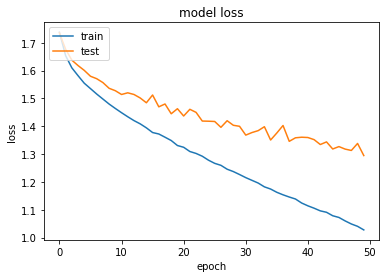

In [12]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# Save model and weights
model_name = 'cnn1d_aug.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("cnn1d_aug.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/cnn1d_aug.h5 


In [14]:
# loading json and model architecture 
json_file = open('cnn1d_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/cnn1d_aug.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 50.99%


In [15]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

7695/7695 [==============================] - 4s 491us/step


array([2, 4, 1, ..., 3, 4, 0])

In [16]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,male_happy,male_happy
172,male_happy,male_happy
173,male_fear,male_disgust
174,male_fear,male_disgust
175,male_fear,male_disgust
176,male_happy,male_happy
177,male_angry,male_angry
178,male_angry,male_disgust
179,male_sad,male_disgust


In [17]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_angry,1212
male_disgust,1066
male_fear,1753
male_happy,1002
male_neutral,1204
male_sad,1255
male_surprise,203


In [19]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.5099415204678363


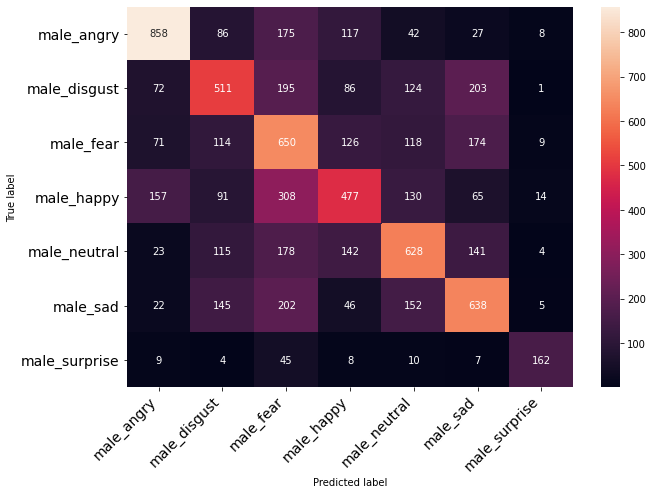

In [20]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [21]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

               precision    recall  f1-score   support

   male_angry       0.71      0.65      0.68      1313
 male_disgust       0.48      0.43      0.45      1192
    male_fear       0.37      0.52      0.43      1262
   male_happy       0.48      0.38      0.43      1242
 male_neutral       0.52      0.51      0.52      1231
     male_sad       0.51      0.53      0.52      1210
male_surprise       0.80      0.66      0.72       245

     accuracy                           0.51      7695
    macro avg       0.55      0.53      0.54      7695
 weighted avg       0.52      0.51      0.51      7695

